In [1]:
# Importando bibliotecas
import pprint
import pandas as pd
import copy
import matplotlib.pyplot as plt

# Importando arquivos
from cycles import calculate_two_evaporators_cycle_with_work_and_f, calculate_two_evaporators_cycle_with_q_evaporators

In [2]:
def determine_if_reached_threshold(value, lower, upper):
    reached_threshold = 0
    if value <= lower:
        reached_threshold = 1
        value = lower
    elif value >= upper:
        reached_threshold = 1
        value = upper  
    return value, reached_threshold

def calculate_next_x(input_values, x, current_cycle, delta, alpha, lower_threshold, upper_threshold):
    current_x = input_values[x]
    input_values_x = copy.copy(input_values)
    input_values_x[x] += delta
    gradient_cycle_x = calculate_two_evaporators_cycle_with_work_and_f(input_values_x)
    gradient_x = (gradient_cycle_x['cop'] - current_cycle['cop']) / delta
    next_x = current_x + alpha * gradient_x
    next_x, reached_threshold_x = determine_if_reached_threshold(next_x, lower_threshold, upper_threshold)
    return next_x, reached_threshold_x

def calculate_next_all(input_values, delta, alpha):
      
    current_cycle = calculate_two_evaporators_cycle_with_work_and_f(input_values)

    # Next superheating_ht
    next_superheating_ht, reached_threshold_superheating_ht = calculate_next_x(input_values, 
                                                                               'superheating_ht', 
                                                                               current_cycle, 
                                                                               delta, 
                                                                               alpha, 
                                                                               input_values['lower_threshold'], 
                                                                               input_values['upper_threshold'])

    # Next superheating_lt
    next_superheating_lt, reached_threshold_superheating_lt = calculate_next_x(input_values, 
                                                                               'superheating_lt', 
                                                                               current_cycle, 
                                                                               delta, 
                                                                               alpha, 
                                                                               input_values['lower_threshold'], 
                                                                               input_values['upper_threshold'])

    # Next subcooling
    next_subcooling, reached_threshold_subcooling = calculate_next_x(input_values, 
                                                                     'subcooling', 
                                                                     current_cycle, 
                                                                     delta, 
                                                                     alpha, 
                                                                     input_values['lower_threshold'], 
                                                                     input_values['upper_threshold'])
    
    # Next f
    next_f, reached_threshold_f = calculate_next_x(input_values, 'f', current_cycle, delta, alpha, 0.3, 0.7)
        
    input_values['superheating_ht'] = next_superheating_ht
    input_values['superheating_lt'] = next_superheating_lt
    input_values['subcooling'] = next_subcooling
    input_values['f'] = next_f
    sum_of_threshold_reached =  reached_threshold_superheating_ht + reached_threshold_superheating_lt \
        + reached_threshold_subcooling + reached_threshold_f
    
    next_cycle = calculate_two_evaporators_cycle_with_work_and_f(input_values)
    
    return sum_of_threshold_reached, current_cycle, next_cycle

def optimize_with_cop(input_values):
    n = 0
    error = 1
    while n < 4 and abs(error) >= 10**(-10):
        n, current_cycle, next_cycle = calculate_next_all(input_values, 10**(-1), 5)
        error = (next_cycle['cop'] - current_cycle['cop'])/((next_cycle['cop'] + current_cycle['cop'])/2)
    optimized_cycle = calculate_two_evaporators_cycle_with_work_and_f(input_values)
    
    return optimized_cycle

def optimize_multiple_refrigerants(default_input_values, input_values, input_ranges):
    original_input_values = copy.copy(input_values)
    results = pd.DataFrame(columns=['refrigerant',
                                    't_external_env',
                                    'month',
                                    'work',
                                    'monthly_energy_consumption',
                                    'monthly_price',
                                    'q_evaporator_ht',
                                    'q_evaporator_lt',
                                    'subcooling',
                                    'superheating_ht',
                                    'superheating_lt',
                                    'f',
                                    'default_f',
                                    'cop',
                                    'default_cop',
                                    'exergy_efficiency',
                                    'default_exergy_efficiency'])
    n = 0
    for refrigerant in input_ranges['refrigerants']:
        for t_external_env_month in input_ranges['t_external_env_month']:
            n += 1
            print(n)
            default_input_values['refrigerant'] = refrigerant
            default_input_values['t_external_env'] = t_external_env_month[1] + 273.15
            default_cycle = calculate_two_evaporators_cycle_with_q_evaporators(default_input_values)
            input_values = copy.copy(original_input_values)
            input_values['work'] = default_cycle['work']
            input_values['refrigerant'] = refrigerant
            input_values['t_external_env'] = t_external_env_month[1] + 273.15
            optimized_cycle = optimize_with_cop(input_values)
            results = results.append({
                'refrigerant': refrigerant,
                't_external_env': t_external_env_month[1],
                'month': t_external_env_month[0],
                'work': optimized_cycle['cycle_inputs']['work'],
                'monthly_energy_consumption': optimized_cycle['cycle_inputs']['work'] * 24 * 30 / 1000,
                'monthly_price': optimized_cycle['cycle_inputs']['work'] * 24 * 30 * 0.694 / 1000,
                'q_evaporator_ht': optimized_cycle['q_evaporator_ht'],
                'q_evaporator_lt': optimized_cycle['q_evaporator_lt'],
                'subcooling': optimized_cycle['cycle_inputs']['subcooling'],
                'superheating_ht': optimized_cycle['cycle_inputs']['superheating_ht'],
                'superheating_lt': optimized_cycle['cycle_inputs']['superheating_lt'],
                'f': optimized_cycle['cycle_inputs']['f'],
                'default_f': default_cycle['f'],
                'cop': optimized_cycle['cop'],
                'default_cop': default_cycle['cop'],
                'exergy_efficiency': optimized_cycle['exergy_efficiency'],
                'default_exergy_efficiency': default_cycle['exergy_efficiency']
            }, ignore_index=True)
    print('Done')
    return results

In [3]:
# Temperatura externa: https://en.climate-data.org/south-america/brazil/rio-de-janeiro/rio-de-janeiro-853/ (media das maximas)
# Temperaturas internas: pagina 18 do arquivo MFL70720817_PB.pdf (LG)
# Refrigerante base: pagina 6 do arquivo MFL70720817_PB.pdf (LG)
# Consumo: pagina 16 do arquivo CATALOGO_10_BRASTEMP (Brastemp)
# Tarifa media do kWh: https://www.aneel.gov.br/ranking-das-tarifas (Light RJ)

# Temperaturas novas por mes: https://www.climatempo.com.br/climatologia/321/riodejaneiro-rj
default_input_values = {
    't_internal_env_ht': 3 + 273.15,
    't_internal_env_lt': -18 + 273.15,
    'approach_condenser': 5,
    'approach_evaporator_ht': 5,
    'approach_evaporator_lt': 5,
    'q_evaporator_ht': 75,
    'q_evaporator_lt': 75,
    'isentropic_efficiency': 0.7,
    'subcooling': 0,
    'superheating_ht': 0,
    'superheating_lt': 0,
}

input_values = {
    't_internal_env_ht': 3 + 273.15,
    't_internal_env_lt': -18 + 273.15,
    'approach_condenser': 5,
    'approach_evaporator_ht': 5,
    'approach_evaporator_lt': 5,
    'f': 0.5,
    'isentropic_efficiency': 0.7,
    'subcooling': 5,
    'superheating_ht': 5,
    'superheating_lt': 5,
    'upper_threshold': 10,
    'lower_threshold': 0
}

input_ranges = {
    'refrigerants': ['R600a', 'R134a', 'R22', 'R290', 'R1234yf', 'NH3'],
    't_external_env_month': [['Janeiro', 29], ['Fevereiro', 30], ['Março', 29], ['Abril', 28],
                             ['Maio', 26], ['Junho', 25], ['Julho', 24], ['Agosto', 25],
                             ['Setembro', 25], ['Outubro', 26], ['Novembro', 27], ['Dezembro', 28]]
}

optimized_table = optimize_multiple_refrigerants(default_input_values, input_values, input_ranges)
optimized_table.to_excel(r'C:\repositories\projeto-final\src\main_optimization.xlsx', index = False)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
Done


<AxesSubplot:xlabel='subcooling', ylabel='cop'>

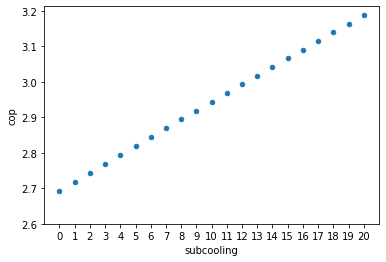

In [4]:
# Usando as variaveis de entrada do Yang (2015).pdf para comparar os ciclos
input_values = {
    't_external_env': 30 + 273.15,
    't_internal_env_ht': -5 + 273.15,
    't_internal_env_lt': -26 + 273.15,
    'approach_condenser': 0,
    'approach_evaporator_ht': 0,
    'approach_evaporator_lt': 0,
    'q_evaporator_ht': 239,
    'q_evaporator_lt': 246,
    'isentropic_efficiency': 0.78,
    'superheating_ht': 0,
    'superheating_lt': 0,
    'refrigerant': 'R600a'
}

input_ranges = {
    'subcooling': range(0,21)
}

original_input_values = copy.copy(input_values)
results = pd.DataFrame(columns=['cop',
                                'subcooling'])
for subcooling in input_ranges['subcooling']:
    input_values = copy.copy(original_input_values)
    input_values['subcooling'] = subcooling
    cycle = calculate_two_evaporators_cycle_with_q_evaporators(input_values)
    results = results.append({
        'cop': cycle['cop'],
        'subcooling': subcooling
    }, ignore_index=True)

results.plot(x='subcooling', y='cop', kind='scatter', xticks=range(0,21), yticks=[2 + (x * 0.1) for x in range(6, 13)])
# pprint.pprint(results)

In [5]:
# Usando as variaveis de entrada do Yang (2015).pdf para comparar os ciclos
input_values = {
    't_external_env': 29 + 273.15,
    't_internal_env_ht': 3 + 273.15,
    't_internal_env_lt': -18 + 273.15,
    'approach_condenser': 5,
    'approach_evaporator_ht': 5,
    'approach_evaporator_lt': 5,
    'q_evaporator_ht': 75,
    'q_evaporator_lt': 75,
    'isentropic_efficiency': 0.7,
    'subcooling': 0,
    'superheating_ht': 0,
    'superheating_lt': 0,
    'refrigerant': 'R600a'
}

cycle = calculate_two_evaporators_cycle_with_q_evaporators(input_values)
print(cycle['cop'], cycle['exergy_efficiency'])

input_values = {
    't_external_env': 29 + 273.15,
    't_internal_env_ht': 3 + 273.15,
    't_internal_env_lt': -18 + 273.15,
    'approach_condenser': 5,
    'approach_evaporator_ht': 5,
    'approach_evaporator_lt': 5,
    'work': 63.11900686619193,
    'f': 0.3,
    'isentropic_efficiency': 0.7,
    'subcooling': 10,
    'superheating_ht': 10,
    'superheating_lt': 10,
    'refrigerant': 'R600a'
}

cycle = calculate_two_evaporators_cycle_with_work_and_f(input_values)
print(cycle['cop'], cycle['exergy_efficiency'])

2.3764632469263964 0.33344889430993896
2.6509090098705306 0.318432738424528
